# Drift detection using autoencoders

In this tutorial we'll see how to leverage the `AutoEncoderDriftDetector` class available on mercury for detecting drift over time on our data.

## 0. About this method

Drift detection, more specifically **covariate shift**, is a setting in which we have a source dataset that comes from a certain joint distribution $\mathcal{D}$ on which we train our models. Over time, the underlying distribution of the data can change (for example, during a pandemic lockdown, a certain feature representing "restaurant spending" will decrease). So, given a new batch of data (usually called target), could we detect whether the underlying distribution of the target sample coming from $\mathcal{D}'$, remains the same as the source, that is $\mathcal{D}=\mathcal{D}'$?

One method for tackling this is using **autoencoders**. We could train an autoencoder to reconstruct our source data and get how much error it makes. Later, we could use it for reconstructing our target dataset. In case the reconstruction error (for example, the *MSE*) remains similar to the one obtained on "*source*", we could assume the new batch of data is "similar" to the reference. Conversely, if the error is higher, that means the new batch of data does not resemble the reference, thus, coming from other distribution and warning us the new distribution may have changed.

In order to have stronger warranties about whether there are differences between the source and target data autoencoder errors, we use an ensemble of autoencoders and perform a statistical test on the recorded errors each one of them make.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from mercury.dataschema import DataSchema
from mercury.dataschema.feature import FeatType

from sklearn import preprocessing

In [3]:
# Reproducibility
np.random.seed(9999)

In [4]:
import matplotlib.pyplot as plt

In [5]:
from mercury.monitoring.drift.auto_encoder_drift_detector import AutoEncoderDriftDetector

<a id="load_dataset"></a>
## 1. Load dataset and setup experiment

We use the wine quality dataset [[1]](#[1]) dataset. The files of this dataset are available inside of the /data/winequality folder in tutorials and it is also available in the [UCI ML repository](https://archive.ics.uci.edu/ml/datasets/wine+quality) 

Each row of the dataset represents a different wine and it contains attributes like the acidity of the wine or the level of alcohol. The dataset also contains the quality of the wine, ranging from 0 to 10. 


In [6]:
df_red_wines = pd.read_csv("../data/winequality/winequality-red.csv")
df_white_wines = pd.read_csv("../data/winequality/winequality-white.csv")

df_red_wines["type"] = "red"
df_white_wines["type"] = "white"

df = pd.concat([df_red_wines, df_white_wines])

### Experiment Setup

We convert this quality to an integer to indicate if it is a high-quality wine or not. We suppose that we have the goal of building a model to predict if a wine will be a high-quality wine given its attributes.


Importantly, to illustrate the drift functionalities and simulate a real situation we introduce a time column. This column represents the time when that wine is available. The important considerations to understand the setup are the next:
- The wines where time is equal to 0 represent the wines available for training a model. ALL these wines have a level of alcohol lower (or equal) than 11.
- We introduce new wines at each timestep. Different from the training set, these new wines can have a level of alcohol higher than 11. For each timestep, we proportion of wines with a higher level of alcohol than 11 grows. The total number of timesteps is 7.

In [7]:
# Create id
df["id"] = np.arange(df.shape[0])

# Encode Label
df["quality"] = df["quality"].apply(lambda x: 1 if x >=7 else 0)

# Encode Type
le = preprocessing.LabelEncoder()
df["type"] = le.fit_transform(df["type"])

# Set attribute to indicate high alcohol
df["high_alcohol"] = df["alcohol"].apply(lambda x: True if x > 11 else False)

# Time will represent the moment we have that data
df["time"] = -1

# For those rows with high alcohol, we set 70% of them as time 0 (they will be used as training)
df["time"] = df.apply(
    lambda x: 0 if (x["high_alcohol"] == False) and (np.random.uniform() < 0.7) else -1, axis=1
 )

# Each timestep, new amount of samples low_alcohol and high_alcohol
n_samples_low_alcohol = [250, 245, 230, 210, 180, 140, 30]
n_samples_high_alcohol = [0, 5, 10, 20, 40, 80, 160]
max_timesteps = 7
for t in range(1, max_timesteps + 1):
    # Sample examples with high_alcohol == True
    n_samples = n_samples_high_alcohol[t-1]
    sampled_ids = df[(df["time"] == -1) & (df["high_alcohol"] == True)].sample(
        n_samples, random_state=2021)["id"].values
    df.loc[df["id"].isin(sampled_ids), "time"] = t
    # Sample examples with high_alcohol == False
    n_samples = n_samples_low_alcohol[t-1]
    sampled_ids = df[(df["time"] == -1) & (df["high_alcohol"] == False)].sample(
        n_samples, random_state=2021)["id"].values
    df.loc[df["id"].isin(sampled_ids), "time"] = t 

In [8]:
df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,id,high_alcohol,time
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,0,0,False,4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,0,1,False,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,0,2,False,0


The next figure shows how the number of wines with low alcohol level decreases over time, while the number of wines with a high level of alcohol increases:

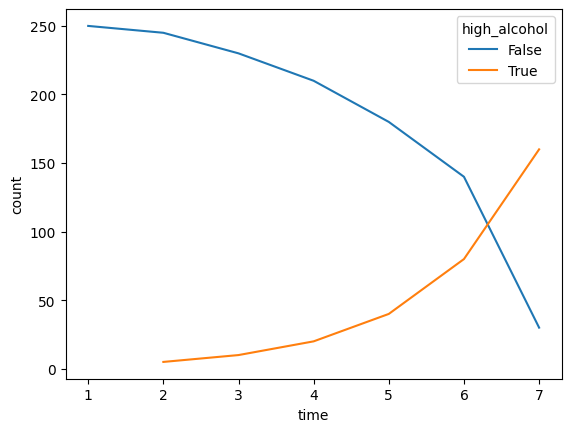

In [9]:
sample_counts = df.groupby(["time", "high_alcohol"])["id"].count().to_frame().reset_index()
sample_counts = sample_counts.rename(columns={"id": "count"})
sample_counts = sample_counts[sample_counts["time"] > 0]
ax = sns.lineplot(x="time", y="count", hue="high_alcohol", data=sample_counts)

In [10]:
label = 'quality'
features = [c for c in df.columns if c not in [label, 'time', 'high_alcohol', 'id']]

Split the dataframe in a source dataset and 6 possible targets, one per timestep.

In [11]:
reference_dataset = df[df["time"] == 0][features].values.copy()
timestep_datasets = [df[df["time"] == i][features].values.copy() for i in range(1, 7)]

Because we will be using autoencoders, it's important we **normalize** the data.

In [12]:
# In this case, the dataset is composed only of numerical features + one binary. So we normalize 
# the numericals.

# Train normalizer on SOURCE
numeric_feats_transformer = preprocessing.PowerTransformer().fit(reference_dataset[:,:-1])

# Apply normalization on all splits
reference_dataset[:,:-1] = numeric_feats_transformer.transform(reference_dataset[:,:-1])
for i in range(len(timestep_datasets)):
    timestep_datasets[i][:,:-1] = numeric_feats_transformer.transform(timestep_datasets[i][:,:-1])

## 2. Drift detection

The class that handles all the behaviour explained on **Section 0** is `AutoEncoderDriftDetector`.

In order to use an `AutoEncoderDriftDetector`, we need to call its `fit` method with a reference dataset. It will train and save `N` internal small autoencoders (default is 30) on several subsamples of SOURCE.

Then, calling `calculate_drift`, the test will be made, returning a dictionary with two items; a p-value for the statistical test under the **null hypothesis ($H_0$) that there is no drift** and a boolean indicator of whether there is drift or not.

In [13]:
from mercury.monitoring.drift.auto_encoder_drift_detector import AutoEncoderDriftDetector

In [14]:
detector = AutoEncoderDriftDetector().fit(reference_dataset)

Metal device set to: Apple M1 Pro


2023-04-04 16:09:04.690706: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-04 16:09:04.690800: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-04-04 16:09:04.753333: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-04 16:09:04.753501: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-04 16:09:04.881497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:09:06.412718: I tensorflow/core/grappler/

2023-04-04 16:09:46.977146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:09:48.399938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:09:48.642650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:09:50.089318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:09:50.334631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:09:51.748286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:09:51.990522: I tensorflow/core/grappler/optimizers/cust

After having fitted the detector, we can check for drift on each one of the subsequent timesteps.

In [15]:
for i in range(len(timestep_datasets)):
    print(f"Drift detection for timestep {i+1} -> {detector.calculate_drift(timestep_datasets[i])}")

2023-04-04 16:09:56.900245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:09:57.226446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:09:57.537826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:09:57.849268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:09:58.159333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:09:58.476902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:09:58.786758: I tensorflow/core/grappler/optimizers/cust

Drift detection for timestep 1 -> {'pval': 1.5099296795810785e-11, 'drift': True}
Drift detection for timestep 2 -> {'pval': 1.5099296795810785e-11, 'drift': True}
Drift detection for timestep 3 -> {'pval': 1.5099296795810785e-11, 'drift': True}
Drift detection for timestep 4 -> {'pval': 1.5099296795810785e-11, 'drift': True}
Drift detection for timestep 5 -> {'pval': 1.5099296795810785e-11, 'drift': True}
Drift detection for timestep 6 -> {'pval': 1.5099296795810785e-11, 'drift': True}


Depending on the execution, drift begins to be detected after the second timestep, when the high alcohol wines start appearing.

The class supports several parameters that allows us tuning its detection performance. The most important are:

- `bootstrap_samples`:  The amount of autoencoders that will be trained. The higher, the more confident the estimate will be, but also the slower.
- `bootstrap_sample_size`: Amount of samples each autoencoder will be trained on (the more, the slower).

Using the `autoencoder_kwargs` (dictionary) argument, one can customize the training of the autoencoders. The supported parameters are:

- `optimizer`: `tf.keras.Optimizer` (or directly a string, the same as what Keras `model.compile` supports)
- `loss`: `tf.keras.Loss` (or directly a string, the same as what Keras `model.compile` supports)
- `batch_size`: Batch size
- `epochs`: Batch size
- `verbose`: Whether to print the keras fit progress bar.

In [16]:
detector = AutoEncoderDriftDetector(
    bootstrap_samples=40,
    autoencoder_kwargs= {'epochs': 5, 'batch_size': 256}
).fit(reference_dataset)

2023-04-04 16:10:52.705721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:10:53.566083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:10:53.986492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:10:54.581683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:10:54.853215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:10:55.374514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:10:55.644345: I tensorflow/core/grappler/optimizers/cust

2023-04-04 16:11:14.878453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:11:15.131426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:11:15.679405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:11:15.939927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:11:16.485681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:11:16.742928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:11:17.301263: I tensorflow/core/grappler/optimizers/cust

In [17]:
result = detector.calculate_drift(timestep_datasets[5], return_errors=True)

2023-04-04 16:11:25.993917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:11:26.332201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:11:26.652852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:11:26.986287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:11:27.331641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:11:27.684121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:11:28.009450: I tensorflow/core/grappler/optimizers/cust

If we pass `return_errors=True` to the `calculate_drift` method, the resulting dictionary will also have two more keys with the source and target errors which we can use for doing further analysis. For example, getting its histograms

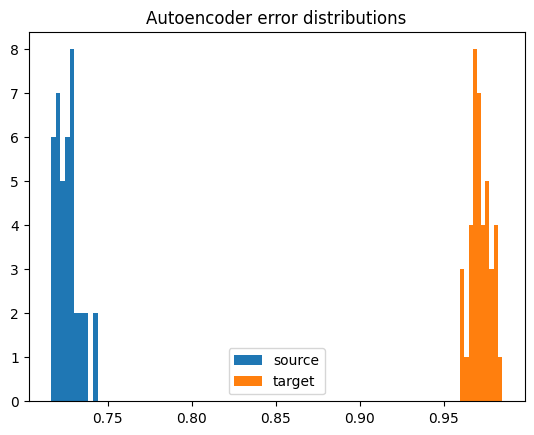

In [18]:
fig, ax = plt.subplots()

ax.hist(result['source_errors'], label='source')
ax.hist(result['target_errors'], label='target')
ax.set_title("Autoencoder error distributions")
ax.legend()

## References

<a id="[1]">[1]</a> 
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.